# MamaCare AI — Recovery Run


In [1]:
# STEP 1: Install (then restart runtime, then skip to Step 2)
!pip install --quiet transformers datasets accelerate peft trl bitsandbytes rouge-score nltk evaluate gradio scikit-learn sentencepiece protobuf
print("Done. Now: Runtime > Restart session, then run from STEP 2.")

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.8 MB/s eta 0:00:00
Done. Now: Runtime > Restart session, then run from STEP 2.


In [3]:
# STEP 2: Imports + Mount Google Drive
import os, re, time, json, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from datasets import load_dataset, Dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, PeftModel, TaskType
from trl import SFTTrainer, SFTConfig
import evaluate
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from sklearn.model_selection import train_test_split

nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

SAVE_DIR = '/content/drive/MyDrive/mamacare'
os.makedirs(SAVE_DIR, exist_ok=True)

BASE_MODEL = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
MAX_SEQ_LEN = 512
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

SYSTEM_PROMPT = (
    "You are MamaCare AI, a compassionate and knowledgeable maternal health "
    "assistant focused on helping pregnant women in Africa. You provide accurate, "
    "evidence-based information about pregnancy, childbirth, postpartum care, "
    "breastfeeding, and maternal health. You help dispel harmful myths and "
    "misconceptions about pregnancy. You always recommend consulting healthcare "
    "providers for medical decisions. If asked about topics outside maternal "
    "health, you politely redirect to your area of expertise."
)

print(f"GPU: {torch.cuda.get_device_name(0)}")
print(f"Drive: {SAVE_DIR}")
print("Ready.")

Mounted at /content/drive
GPU: Tesla T4
Drive: /content/drive/MyDrive/mamacare
Ready.


In [4]:
# STEP 3: Keep Colab alive (prevents disconnect)
# Run this cell, then continue with the rest. It runs in the background.
import IPython
IPython.display.display(IPython.display.Javascript('''
function keepAlive() {
    document.querySelector("colab-connect-button")?.click();
    console.log("Keep-alive ping: " + new Date().toLocaleTimeString());
}
setInterval(keepAlive, 60000);
keepAlive();
'''))
print("Keep-alive active. Colab will stay connected.")

<IPython.core.display.Javascript object>

Keep-alive active. Colab will stay connected.


In [5]:
# STEP 4: Load all 3 datasets
print("[1/3] maternalcareeng...")
ds1 = load_dataset("nashrah18/maternalcareeng", split="train").to_pandas()
ds1 = ds1.rename(columns={"Q":"question","A":"answer"})
ds1["source"] = "maternalcareeng"
print(f"  {len(ds1)} rows")

print("[2/3] ai-medical-chatbot (filtering)...")
ds2_full = load_dataset("ruslanmv/ai-medical-chatbot", split="train").to_pandas()
kw = ['pregnan','prenatal','antenatal','trimester','fetus','fetal',
      'baby','newborn','infant','neonatal','breastfeed','lactation',
      'labor','labour','delivery','childbirth','postpartum','postnatal',
      'c-section','cesarean','miscarriage','ectopic','ovulation',
      'fertility','conception','morning sickness','preeclampsia',
      'gestational','placenta','amniotic','umbilical','contraction',
      'cervix','obstetr','gynecol','midwife','maternal','maternity',
      'folate','folic acid','uterus','uterine','womb']
pat = '|'.join(kw)
mask = (ds2_full['Description'].str.contains(pat, case=False, na=False) |
        ds2_full['Doctor'].str.contains(pat, case=False, na=False))
ds2 = ds2_full[mask][["Description","Doctor"]].copy()
ds2 = ds2.rename(columns={"Description":"question","Doctor":"answer"})
ds2["source"] = "ai_medical_chatbot"
if len(ds2) > 2500:
    ds2 = ds2.sample(n=2500, random_state=SEED)
print(f"  {len(ds2)} rows")
del ds2_full

print("[3/3] Custom myths...")
custom_data = [
    {"question": "Is it true that pregnant women should not eat eggs because the baby will be born bald?",
     "answer": "No, this is a myth. Eggs are an excellent source of protein, iron, and choline, which are essential for your baby's brain development. Eating eggs during pregnancy is healthy and recommended. Your baby's hair growth is determined by genetics, not by what you eat."},
    {"question": "My grandmother says I should not eat snails during pregnancy or my baby will drool excessively. Is this true?",
     "answer": "This is a common myth with no scientific basis. Snails are actually a good source of protein and iron, which are important during pregnancy. Your baby's drooling is a normal developmental process and has nothing to do with eating snails. However, make sure any snails you eat are properly cooked to avoid infections."},
    {"question": "People say if I eat spicy food during pregnancy, my baby will be blind. Should I avoid spices?",
     "answer": "This is completely false. Eating spicy food during pregnancy does not cause blindness or any eye problems in babies. Moderate amounts of spicy food are safe during pregnancy. However, if spicy food causes you heartburn or discomfort, you may want to eat less of it for your own comfort."},
    {"question": "Is it true that eating coconut during pregnancy will make my baby have a light complexion?",
     "answer": "No, this is a myth. Your baby's skin color is determined entirely by genetics inherited from both parents. Coconut is actually nutritious and safe to eat during pregnancy in moderate amounts. No food can change your baby's skin color."},
    {"question": "My neighbor told me eating okra during pregnancy will make my baby produce too much saliva. Is this true?",
     "answer": "This is a myth. Okra is actually a nutritious vegetable that provides fiber, folate, and vitamin C, all of which are beneficial during pregnancy. Your baby's saliva production is a normal body function and is not affected by eating okra."},
    {"question": "Should pregnant women avoid fish entirely as some people in my village recommend?",
     "answer": "No, you should not avoid fish entirely. Fish is an important source of omega-3 fatty acids, protein, and vitamins that support your baby's brain and eye development. However, avoid fish with high mercury levels such as shark, swordfish, and king mackerel. Eating 2-3 servings of well-cooked low-mercury fish per week is recommended."},
    {"question": "Is it true that eating plantain during pregnancy makes the baby too big for delivery?",
     "answer": "This is a myth. Plantain is a nutritious food that provides energy, potassium, and fiber. Baby size is influenced by genetics, overall nutrition, and maternal health conditions like gestational diabetes, not by eating any single food."},
    {"question": "People say I must eat for two now that I am pregnant. How much should I actually eat?",
     "answer": "You do not need to literally eat for two. During the first trimester, you do not need any extra calories. In the second trimester, you need about 340 extra calories per day, and in the third trimester, about 450 extra calories. Focus on nutrient-dense foods rather than simply eating more."},
    {"question": "My mother says I should not raise my hands above my head during pregnancy because the umbilical cord will wrap around the baby's neck. Is this true?",
     "answer": "This is a very common myth that is completely false. Raising your arms above your head does not cause the umbilical cord to wrap around your baby's neck. Cord wrapping happens naturally due to baby movement in the womb. Light stretching and normal arm movements are safe during pregnancy."},
    {"question": "Is it true that if I look at ugly or disabled people during pregnancy, my baby will be affected?",
     "answer": "Absolutely not. This is a harmful myth. What you look at during pregnancy has zero effect on your baby's appearance or health. Your baby's development is determined by genetics and nutrition. This myth is not only false but also disrespectful to people with disabilities."},
    {"question": "People say pregnant women should not go out during a solar eclipse or the baby will have a birthmark. Is this true?",
     "answer": "This is a myth with no scientific basis. Solar eclipses are natural astronomical events that have no effect on pregnancy. Birthmarks are caused by clusters of blood vessels or melanin under the skin, not by eclipses."},
    {"question": "Is it wrong to announce my pregnancy early? Some say it brings bad luck.",
     "answer": "There is no medical reason why announcing your pregnancy early would cause any harm. The decision of when to share your pregnancy news is entirely personal. What matters most is getting early prenatal care as soon as you know you are pregnant."},
    {"question": "Can a pregnant woman attend a funeral? My family says it will harm the baby.",
     "answer": "Attending a funeral will not harm your baby in any way. This is a cultural belief with no medical basis. However, funerals can be emotionally stressful, and stress management is important during pregnancy. If you feel it will be too overwhelming, it is okay to stay home for your own emotional wellbeing."},
    {"question": "My aunt says I should not sew or knot anything during pregnancy or the baby will get tangled in the cord. Is this true?",
     "answer": "This is completely untrue. Sewing, knitting, or tying knots has absolutely no effect on the umbilical cord. The baby's cord is inside the womb and is not affected by anything you do with your hands outside your body."},
    {"question": "Is it safe to use traditional herbal medicines during pregnancy?",
     "answer": "Many traditional herbal remedies have NOT been tested for safety during pregnancy and some can be very dangerous. Some herbs can cause contractions, bleeding, miscarriage, or birth defects. Always consult your doctor or midwife before taking any herbal medicine during pregnancy."},
    {"question": "My traditional healer gave me herbs to make my baby strong. Should I take them?",
     "answer": "Please do NOT take these herbs without first consulting your doctor or midwife. Many traditional herbal preparations contain unknown quantities of active ingredients that can harm your baby. The best way to make your baby strong is through proper nutrition, prenatal vitamins, regular antenatal visits, and adequate rest."},
    {"question": "Is it true that drinking palm wine or local brew helps with labor pain?",
     "answer": "No, alcohol in any form is dangerous during pregnancy. Drinking palm wine, local brew, or any alcohol can cause Fetal Alcohol Spectrum Disorders, leading to brain damage, growth problems, and facial abnormalities. There is no safe amount of alcohol during pregnancy."},
    {"question": "Some women in my community use herbs to induce labor when overdue. Is this safe?",
     "answer": "This is very dangerous. Using herbs to induce labor can cause violent contractions that can rupture your uterus, cut off oxygen to your baby, or cause excessive bleeding. If you are overdue, please visit your healthcare facility. Doctors have safe methods to induce labor when necessary."},
    {"question": "Is it true that rubbing certain oils on my belly will make delivery easier?",
     "answer": "While gentle belly massage with safe oils like coconut oil or shea butter can help with skin elasticity and comfort, no oil will make your actual delivery easier. What helps with delivery is regular antenatal visits, staying active with gentle exercise, proper nutrition, and delivering at a health facility."},
    {"question": "Is it true that if I carry my baby high, it is a girl, and if I carry low, it is a boy?",
     "answer": "No, this is a common myth. How you carry your baby depends on your muscle tone, body shape, and the baby's position, not the baby's gender. The only reliable ways to determine gender are ultrasound after 18-20 weeks or genetic testing."},
    {"question": "People say that bad morning sickness means I am having a girl. Is this true?",
     "answer": "Morning sickness severity is not a reliable gender predictor. Many women with severe nausea have boys, and many with mild nausea have girls. Morning sickness is caused by hormonal changes and varies from woman to woman."},
    {"question": "Is it true that I should limit my water intake during pregnancy to prevent the baby from drowning in fluid?",
     "answer": "Absolutely NOT. This is a very dangerous myth. You need at least 8-10 glasses of water daily. Water helps form amniotic fluid, carry nutrients to your baby, prevent infections, and reduce swelling. Your baby cannot drown in amniotic fluid. Dehydration during pregnancy can lead to serious complications."},
    {"question": "My mother-in-law says I should eat clay or soil during pregnancy for the baby. Is this safe?",
     "answer": "Eating soil is NOT safe. Soil can contain harmful parasites, bacteria, lead, and toxins. These cravings called pica may indicate iron deficiency. Please tell your healthcare provider who can test your iron levels and give you safe iron supplements instead."},
    {"question": "Someone told me that I should not go to the hospital for delivery, that home birth is more natural. What should I do?",
     "answer": "Delivering at a healthcare facility with skilled birth attendants is much safer. Complications like heavy bleeding or obstructed labor can happen suddenly and require immediate medical intervention. Delivering at a health facility significantly reduces the risk of death for both mother and baby."},
    {"question": "Is it true pregnant women should not take any modern medicine?",
     "answer": "This is a dangerous myth. Prenatal vitamins, iron supplements, folic acid, and malaria prevention medication are all important during pregnancy. Your doctor can prescribe safe medicines when you are sick. Avoiding all modern medicine puts you and your baby at serious risk."},
    {"question": "What foods are important during pregnancy in Africa?",
     "answer": "Focus on locally available nutritious foods: dark leafy greens like spinach, amaranth, and pumpkin leaves for iron and folate; beans, lentils, and groundnuts for protein; eggs and milk for protein and calcium; fish for omega-3s; sweet potatoes and carrots for vitamin A; fruits like oranges, mangoes, and pawpaw for vitamin C; and whole grains like millet and sorghum for energy."},
    {"question": "Why is folic acid important and when should I start taking it?",
     "answer": "Folic acid helps prevent neural tube defects like spina bifida in your baby's brain and spine. Start taking 400 micrograms daily at least one month before conception and continue through the first 12 weeks. If already pregnant, start immediately. Foods rich in folate include dark green vegetables and beans."},
    {"question": "How can I prevent malaria during pregnancy?",
     "answer": "Malaria during pregnancy is very dangerous. To prevent it: sleep under an insecticide-treated mosquito net every night, take preventive antimalarial medication given at antenatal visits, wear long-sleeved clothing in the evening, and eliminate standing water where mosquitoes breed. Attend all antenatal appointments."},
    {"question": "How often should I attend antenatal clinic visits?",
     "answer": "The WHO recommends at least 8 antenatal visits: first visit before 12 weeks, then at 20, 26, 30, 34, 36, 38, and 40 weeks. These visits monitor your health and baby's growth, detect problems early, and provide essential supplements and vaccinations."},
    {"question": "What are the danger signs during pregnancy that require immediate medical attention?",
     "answer": "Go to the health facility immediately if you experience: severe headache with blurred vision, vaginal bleeding, high fever, severe abdominal pain, convulsions, sudden swelling of face or hands, baby stops moving or moves less than usual, water breaking before labor, or feeling very weak and dizzy. These can be life-threatening."},
    {"question": "What is preeclampsia and why should I be concerned?",
     "answer": "Preeclampsia is a serious condition with high blood pressure and protein in urine, usually after 20 weeks. Warning signs include severe headaches, vision problems, upper abdominal pain, and sudden swelling. If untreated, it can cause seizures, organ damage, and death. Regular antenatal visits help detect it early."},
    {"question": "What happens during the first trimester of pregnancy?",
     "answer": "During the first trimester (weeks 1-12), your baby's major organs begin forming. You may experience morning sickness, fatigue, breast tenderness, and frequent urination. This is the most critical time for taking folic acid. Attend your first antenatal visit and avoid alcohol, smoking, and harmful substances."},
    {"question": "What should I expect during the second trimester?",
     "answer": "The second trimester (weeks 13-26) is often the most comfortable period. Morning sickness usually improves and you will start feeling baby move between 16-25 weeks. Your belly will grow noticeably. Continue antenatal visits, eat well, stay active with gentle exercise, and start planning for delivery."},
    {"question": "What happens in the third trimester and how do I prepare for birth?",
     "answer": "In the third trimester (weeks 27-40), your baby grows rapidly. Prepare by: choosing where to deliver, saving money for transport, identifying a blood donor, packing a hospital bag, learning signs of labor, and having a birth companion ready. Attend all remaining antenatal visits and watch for danger signs."},
    {"question": "When should I start breastfeeding after birth?",
     "answer": "Start breastfeeding within the first hour after birth. The first milk called colostrum is thick, yellowish, and extremely important for your baby's immune system. Do NOT discard colostrum. Breastfeed exclusively for the first 6 months of life."},
    {"question": "Is it true that I should give my newborn water, sugar water, or herbal water before breastmilk?",
     "answer": "No, this is a harmful practice. Newborn babies should receive ONLY breast milk for the first 6 months. Giving water or herbal concoctions can introduce infections, reduce milk supply, and deprive babies of perfect nutrition. Breast milk contains all the water your baby needs, even in hot climates."},
    {"question": "How can I know if my baby is getting enough breast milk?",
     "answer": "Your baby is getting enough milk if they feed 8-12 times in 24 hours, have 6+ wet diapers per day after day 4, are gaining weight steadily, and seem satisfied after feeds. The more you breastfeed, the more milk you produce. If concerned, visit a health worker."},
    {"question": "What is postpartum depression and how do I recognize it?",
     "answer": "Postpartum depression causes persistent sadness, loss of interest, difficulty bonding with baby, excessive crying, appetite or sleep changes, overwhelming fatigue, and feelings of worthlessness. This is a medical condition, not weakness. Please speak to your healthcare provider if you experience these symptoms."},
    {"question": "Is it true that breastfeeding alone prevents pregnancy?",
     "answer": "Breastfeeding is NOT a reliable contraception method on its own. The Lactational Amenorrhea Method only works if all three conditions are met: baby under 6 months, exclusively breastfeeding day and night, and period has not returned. Even then it is only about 98% effective. Discuss family planning with your provider."},
    {"question": "How soon after giving birth can I get pregnant again?",
     "answer": "You can get pregnant as soon as 3 weeks after delivery, even before your period returns and while breastfeeding. The WHO recommends waiting at least 2 years between pregnancies for full recovery. Talk to your healthcare provider about contraception."},
    {"question": "Can an HIV-positive mother have a healthy baby?",
     "answer": "Yes! With proper antiretroviral medication taken throughout pregnancy, delivery, and breastfeeding, the risk of transmitting HIV to your baby can be reduced to less than 2%. Get tested early, start treatment immediately if positive, and attend all antenatal visits."},
    {"question": "Is it safe to exercise during pregnancy?",
     "answer": "Yes, moderate exercise is safe and beneficial. Aim for 30 minutes most days. Safe activities include walking, swimming, and prenatal yoga. Exercise reduces back pain, improves sleep, manages weight, and prepares your body for labor. Avoid contact sports and exercises lying flat after the first trimester."},
    {"question": "What vaccinations do I need during pregnancy?",
     "answer": "Important vaccinations include tetanus toxoid to protect your baby from neonatal tetanus, which is especially important in Africa. Your provider may also recommend flu and COVID-19 vaccines. Avoid live vaccines like MMR during pregnancy. Attend antenatal visits for all recommended vaccinations."},
    {"question": "My legs are very swollen during pregnancy. Is this dangerous?",
     "answer": "Mild swelling in feet and legs is common in the third trimester. To reduce it: elevate your feet, avoid standing long, wear comfortable shoes, sleep on your left side, and drink plenty of water. However, sudden severe swelling especially in face and hands can signal preeclampsia. Seek immediate care if swelling is sudden or accompanied by headaches."},
    {"question": "What is gestational diabetes and how does it affect my baby?",
     "answer": "Gestational diabetes is high blood sugar during pregnancy. It can cause baby to grow too large, increase risk of premature birth, and cause low blood sugar in baby after birth. Manage it with balanced diet, exercise, blood sugar monitoring, and medication if prescribed."},
    {"question": "How do I know when I am in labor?",
     "answer": "Signs of labor include: regular contractions getting stronger and closer together, bloody mucus discharge, water breaking, and lower back pain in waves. When contractions are 5 minutes apart and lasting 60 seconds, go to the hospital. If water breaks, go immediately even without contractions."},
    {"question": "Can stress during pregnancy affect my baby?",
     "answer": "Yes, severe or prolonged stress can increase risk of preterm birth, low birth weight, and affect baby's brain development. Manage stress by talking to supportive people, relaxation techniques, gentle exercise, adequate sleep, and seeking help for problems. Talk to your healthcare provider if stress feels overwhelming."},
    {"question": "Is morning sickness dangerous for my baby?",
     "answer": "Normal morning sickness is not dangerous for your baby. It usually improves by week 14-16. However, severe persistent vomiting called hyperemesis gravidarum can lead to dehydration. Seek help if you cannot keep food or water down for 24+ hours, lose weight, feel very dizzy, or have dark urine."},
    {"question": "Is it safe to fast during pregnancy for religious reasons?",
     "answer": "Fasting can be risky as you and baby need regular nutrition. Most religious authorities allow pregnant women exemptions. If you fast, break it with nutritious foods, stay hydrated during eating hours, rest, and stop immediately if you feel unwell or notice reduced baby movement. Consult your doctor."},
    {"question": "What should I pack in my hospital bag for delivery?",
     "answer": "Pack: antenatal card and ID, clean clothes for you and baby, sanitary pads, underwear, baby blankets, diapers, water bottle, toiletries, phone and charger, money for emergencies. Also prepare: transport arrangements, support person, childcare plan for other children. Have bag ready by 36 weeks."},
    {"question": "What are the benefits of delayed cord clamping?",
     "answer": "Delayed cord clamping means waiting 1-3 minutes after birth before cutting the cord. Benefits include increased blood volume and iron stores for baby, helping prevent anemia. The WHO recommends this for all births. Discuss with your healthcare provider."},
    {"question": "Can you help me with my math homework?",
     "answer": "I am MamaCare AI, a maternal health assistant. I am specifically designed to help with questions about pregnancy, childbirth, and maternal health. I cannot help with math homework, but I would be happy to answer any questions about pregnancy or baby care."},
    {"question": "What is the weather like today?",
     "answer": "I am MamaCare AI, focused on maternal and pregnancy health. I cannot provide weather information, but I am here to help with any questions about pregnancy, childbirth, breastfeeding, or maternal health."},
    {"question": "Tell me a joke",
     "answer": "While I appreciate the lighthearted request, I am specialized in maternal health topics. I am always here if you have questions about pregnancy, baby care, nutrition during pregnancy, or any other maternal health concerns."},
    {"question": "Who is the president of Nigeria?",
     "answer": "I am MamaCare AI, a maternal health assistant. I focus specifically on pregnancy, childbirth, and maternal health questions. I am not able to answer political questions, but please ask me about anything related to maternal and baby health."},
]
ds3 = pd.DataFrame(custom_data)
ds3["source"] = "custom_myths"
print(f"  {len(ds3)} rows")

df = pd.concat([ds1, ds2, ds3], ignore_index=True)
print(f"\nTotal: {len(df)} rows")

[1/3] maternalcareeng...


README.md:   0%|          | 0.00/327 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/14.8k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/105 [00:00<?, ? examples/s]

  105 rows
[2/3] ai-medical-chatbot (filtering)...


README.md:   0%|          | 0.00/863 [00:00<?, ?B/s]

dialogues.parquet:   0%|          | 0.00/142M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/256916 [00:00<?, ? examples/s]

  2500 rows
[3/3] Custom myths...
  55 rows

Total: 2660 rows


config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

Clean: 2221 rows | Train: 1998 | Val: 223


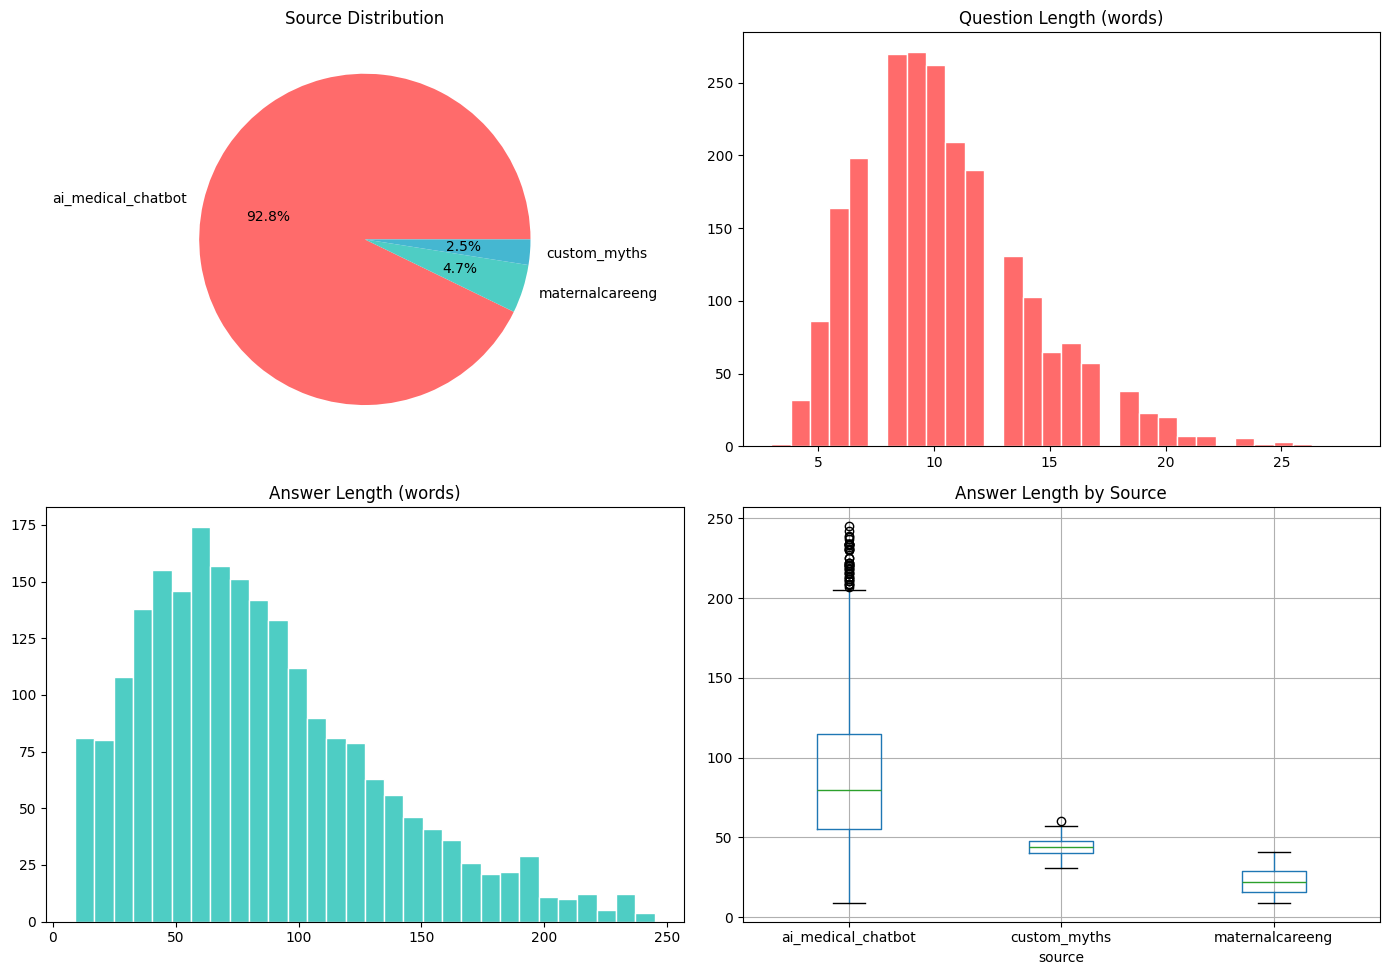

Questions: mean=10 words | Answers: mean=84 words


In [6]:
# STEP 5: Preprocess + Tokenize
def clean_text(t):
    if not isinstance(t, str): return ""
    return re.sub(r'[^\w\s.,!?;:\'\-/()%\"]', '', re.sub(r'\s+', ' ', t).strip())

df = df.dropna(subset=["question","answer"]).reset_index(drop=True)
df["question"] = df["question"].apply(clean_text)
df["answer"] = df["answer"].apply(clean_text)
df = df[(df["question"].str.len()>10) & (df["answer"].str.len()>10)].reset_index(drop=True)
df = df.drop_duplicates(subset=["question"], keep="first").reset_index(drop=True)

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side = "right"

def format_chat(row):
    return (
        f"<|system|>\n{SYSTEM_PROMPT}</s>\n"
        f"<|user|>\n{row['question']}</s>\n"
        f"<|assistant|>\n{row['answer']}</s>"
    )

df["text"] = df.apply(format_chat, axis=1)
df["tokens"] = df["text"].apply(lambda x: len(tokenizer.encode(x)))
df = df[df["tokens"] <= MAX_SEQ_LEN].reset_index(drop=True)

train_df, val_df = train_test_split(df, test_size=0.1, random_state=SEED, stratify=df["source"])
train_ds = Dataset.from_pandas(train_df[["text"]].reset_index(drop=True))
val_ds = Dataset.from_pandas(val_df[["text"]].reset_index(drop=True))
print(f"Clean: {len(df)} rows | Train: {len(train_ds)} | Val: {len(val_ds)}")

# Exploration charts
df["q_words"] = df["question"].str.split().str.len()
df["a_words"] = df["answer"].str.split().str.len()
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("MamaCare AI - Dataset Exploration", fontsize=14, fontweight='bold')
src = df["source"].value_counts()
axes[0,0].pie(src.values, labels=src.index, autopct='%1.1f%%', colors=['#FF6B6B','#4ECDC4','#45B7D1'])
axes[0,0].set_title("Source Distribution")
axes[0,1].hist(df["q_words"], bins=30, color='#FF6B6B', edgecolor='white')
axes[0,1].set_title("Question Length (words)")
axes[1,0].hist(df["a_words"], bins=30, color='#4ECDC4', edgecolor='white')
axes[1,0].set_title("Answer Length (words)")
df.boxplot(column="a_words", by="source", ax=axes[1,1])
axes[1,1].set_title("Answer Length by Source")
plt.suptitle("")
plt.tight_layout(); plt.show()
print(f"Questions: mean={df['q_words'].mean():.0f} words | Answers: mean={df['a_words'].mean():.0f} words")

In [7]:
# STEP 6: Load base model
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True, bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16, bnb_4bit_use_double_quant=True,
)
print(f"Loading {BASE_MODEL}...")
base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL, quantization_config=bnb_config,
    device_map="auto", trust_remote_code=True, use_cache=False,
)
base_model = prepare_model_for_kbit_training(base_model)

lora_config = LoraConfig(
    r=16, lora_alpha=32,
    target_modules=["q_proj","k_proj","v_proj","o_proj","gate_proj","up_proj","down_proj"],
    lora_dropout=0.05, bias="none", task_type=TaskType.CAUSAL_LM,
)
print(f"Loaded. GPU: {torch.cuda.memory_allocated()/1e9:.2f} GB")

Loading TinyLlama/TinyLlama-1.1B-Chat-v1.0...


model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Loaded. GPU: 1.04 GB


---
## STEP 7: TRAIN (saves checkpoints to Google Drive every 50 steps)

Checkpoints go directly to Google Drive. If Colab disconnects, your model is safe. You can resume or just use the last checkpoint.

In [9]:
# Experiment 1: Baseline (1 epoch, fast)
EXP1_DIR = f"{SAVE_DIR}/exp1_baseline"
os.makedirs(EXP1_DIR, exist_ok=True)

model1 = get_peft_model(base_model, lora_config)
model1.print_trainable_parameters()

args1 = SFTConfig(
    output_dir=EXP1_DIR,  # Saves directly to Google Drive!
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,
    learning_rate=2e-4,
    warmup_ratio=0.03,
    weight_decay=0.01,
    optim="paged_adamw_32bit",
    lr_scheduler_type="cosine",
    logging_steps=20,
    eval_strategy="steps",
    eval_steps=200,
    save_strategy="steps",
    save_steps=50,           # Save checkpoint every 50 steps to Drive
    save_total_limit=2,      # Keep last 2 checkpoints
    fp16=False, # Changed to False
    bf16=True,  # Added bf16=True
    dataset_text_field="text",
    seed=SEED,
    report_to="none",
)

trainer1 = SFTTrainer(
    model=model1, args=args1,
    train_dataset=train_ds, eval_dataset=val_ds,
    processing_class=tokenizer,
)

torch.cuda.reset_peak_memory_stats()
t0 = time.time()
r1 = trainer1.train()
t1 = (time.time()-t0)/60
e1 = trainer1.evaluate()

exp1_results = {
    "experiment": "exp1_baseline", "lr": 2e-4, "batch_size": 8, "epochs": 1,
    "train_loss": round(r1.training_loss, 4),
    "eval_loss": round(e1["eval_loss"], 4),
    "perplexity": round(np.exp(e1["eval_loss"])),
    "time_min": round(t1, 1),
    "gpu_gb": round(torch.cuda.max_memory_allocated()/1e9, 2),
}

# Save final model + results
trainer1.model.save_pretrained(EXP1_DIR)
tokenizer.save_pretrained(EXP1_DIR)
pd.DataFrame([exp1_results]).to_csv(f"{SAVE_DIR}/experiment_results.csv", index=False)

print(f"\nEXP1 DONE:")
print(f"  Train Loss: {exp1_results['train_loss']}")
print(f"  Eval Loss:  {exp1_results['eval_loss']}")
print(f"  Perplexity: {exp1_results['perplexity']}")
print(f"  Time: {exp1_results['time_min']} min")
print(f"  Saved to: {EXP1_DIR}")

warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.


trainable params: 12,615,680 || all params: 1,112,664,064 || trainable%: 1.1338


Adding EOS to train dataset:   0%|          | 0/1998 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/1998 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/1998 [00:00<?, ? examples/s]

Adding EOS to eval dataset:   0%|          | 0/223 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/223 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/223 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss



EXP1 DONE:
  Train Loss: 1.3144
  Eval Loss:  1.2246
  Perplexity: 3
  Time: 48.6 min
  Saved to: /content/drive/MyDrive/mamacare/exp1_baseline


In [10]:
# Experiment 2: Final (3 epochs, better results)
EXP2_DIR = f"{SAVE_DIR}/exp2_final"
os.makedirs(EXP2_DIR, exist_ok=True)

model2 = get_peft_model(base_model, lora_config)

args2 = SFTConfig(
    output_dir=EXP2_DIR,  # Saves directly to Google Drive!
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,
    learning_rate=1e-4,
    warmup_ratio=0.05,
    weight_decay=0.001,
    optim="paged_adamw_32bit",
    lr_scheduler_type="cosine",
    logging_steps=20,
    eval_strategy="steps",
    eval_steps=200,
    save_strategy="steps",
    save_steps=50,           # Save checkpoint every 50 steps to Drive
    save_total_limit=2,      # Keep last 2 checkpoints
    fp16=False,
        bf16=True,  # Added bf16=True

    dataset_text_field="text",
    seed=SEED,
    report_to="none",
)

trainer2 = SFTTrainer(
    model=model2, args=args2,
    train_dataset=train_ds, eval_dataset=val_ds,
    processing_class=tokenizer,
)

torch.cuda.reset_peak_memory_stats()
t0 = time.time()
r2 = trainer2.train()
t2 = (time.time()-t0)/60
e2 = trainer2.evaluate()

exp2_results = {
    "experiment": "exp2_final", "lr": 1e-4, "batch_size": 8, "epochs": 3,
    "train_loss": round(r2.training_loss, 4),
    "eval_loss": round(e2["eval_loss"], 4),
    "perplexity": round(np.exp(e2["eval_loss"]), 2),
    "time_min": round(t2, 1),
    "gpu_gb": round(torch.cuda.max_memory_allocated()/1e9, 2),
}

# Save final model + update results
trainer2.model.save_pretrained(EXP2_DIR)
tokenizer.save_pretrained(EXP2_DIR)
all_results = [exp1_results, exp2_results]
rdf = pd.DataFrame(all_results)
rdf["improvement_%"] = round((rdf.iloc[0]["eval_loss"] - rdf["eval_loss"]) / rdf.iloc[0]["eval_loss"] * 100, 1)
rdf.to_csv(f"{SAVE_DIR}/experiment_results.csv", index=False)

print(f"\nEXP2 DONE:")
print(f"  Train Loss: {exp2_results['train_loss']}")
print(f"  Eval Loss:  {exp2_results['eval_loss']}")
print(f"  Perplexity: {exp2_results['perplexity']}")
print(f"  Time: {exp2_results['time_min']} min")
print(f"  Saved to: {EXP2_DIR}")

warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.


Adding EOS to train dataset:   0%|          | 0/1998 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/1998 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/1998 [00:00<?, ? examples/s]

Adding EOS to eval dataset:   0%|          | 0/223 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/223 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/223 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss
200,1.179545,1.196281


Step,Training Loss,Validation Loss
200,1.179545,1.196281



EXP2 DONE:
  Train Loss: 1.2362
  Eval Loss:  1.185
  Perplexity: 3.27
  Time: 148.0 min
  Saved to: /content/drive/MyDrive/mamacare/exp2_final


In [18]:
# Experiment 3: Low LR, small batch, 2 epochs
EXP3_DIR = f"{SAVE_DIR}/exp3_low_lr"
os.makedirs(EXP3_DIR, exist_ok=True)

model3 = get_peft_model(base_model, lora_config)

args3 = SFTConfig(
    output_dir=EXP3_DIR,
    num_train_epochs=2,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,  # effective batch = 4*4 = 16
    learning_rate=5e-5,
    warmup_ratio=0.05,
    weight_decay=0.01,
    optim="paged_adamw_32bit",
    lr_scheduler_type="cosine",
    logging_steps=20,
    eval_strategy="steps",
    eval_steps=200,
    save_strategy="steps",
    save_steps=50,
    save_total_limit=2,
    fp16=False,
    bf16=True,  # Added bf16=True

    dataset_text_field="text",
    seed=SEED,
    report_to="none",
)

trainer3 = SFTTrainer(
    model=model3, args=args3,
    train_dataset=train_ds, eval_dataset=val_ds,
    processing_class=tokenizer,
)

torch.cuda.reset_peak_memory_stats()
t0 = time.time()
r3 = trainer3.train()
t3 = (time.time()-t0)/60
e3 = trainer3.evaluate()

exp3_results = {
    "experiment": "exp3_low_lr", "lr": 5e-5, "batch_size": 4, "epochs": 2,
    "train_loss": round(r3.training_loss, 4),
    "eval_loss": round(e3["eval_loss"], 4),
    "perplexity": round(np.exp(e3["eval_loss"]), 2),
    "time_min": round(t3, 1),
    "gpu_gb": round(torch.cuda.max_memory_allocated()/1e9, 2),
}

trainer3.model.save_pretrained(EXP3_DIR)
tokenizer.save_pretrained(EXP3_DIR)

# Update results table with all 3 experiments
all_results = [exp1_results, exp2_results, exp3_results]
rdf = pd.DataFrame(all_results)
rdf["improvement_%"] = round((rdf.iloc[0]["eval_loss"] - rdf["eval_loss"]) / rdf.iloc[0]["eval_loss"] * 100, 1)
rdf.to_csv(f"{SAVE_DIR}/experiment_results.csv", index=False)

print(f"\nEXP3 DONE:")
print(f"  Train Loss: {exp3_results['train_loss']}")
print(f"  Eval Loss:  {exp3_results['eval_loss']}")
print(f"  Perplexity: {exp3_results['perplexity']}")
print(f"  Time: {exp3_results['time_min']} min")
print(f"  Saved to: {EXP3_DIR}")
print(f"\nALL 3 EXPERIMENTS:")
print(rdf.to_string(index=False))

warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.


Adding EOS to train dataset:   0%|          | 0/1998 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/1998 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/1998 [00:00<?, ? examples/s]

Adding EOS to eval dataset:   0%|          | 0/223 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/223 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/223 [00:00<?, ? examples/s]

NotImplementedError: "_amp_foreach_non_finite_check_and_unscale_cuda" not implemented for 'BFloat16'


HYPERPARAMETER RESULTS
   experiment     lr  batch_size  epochs  train_loss  eval_loss  perplexity  time_min  gpu_gb  improvement_%
exp1_baseline 0.0002           8       1      1.3144     1.2246        3.00      48.6    3.74            0.0
   exp2_final 0.0001           8       3      1.2362     1.1850        3.27     148.0    3.86            3.2


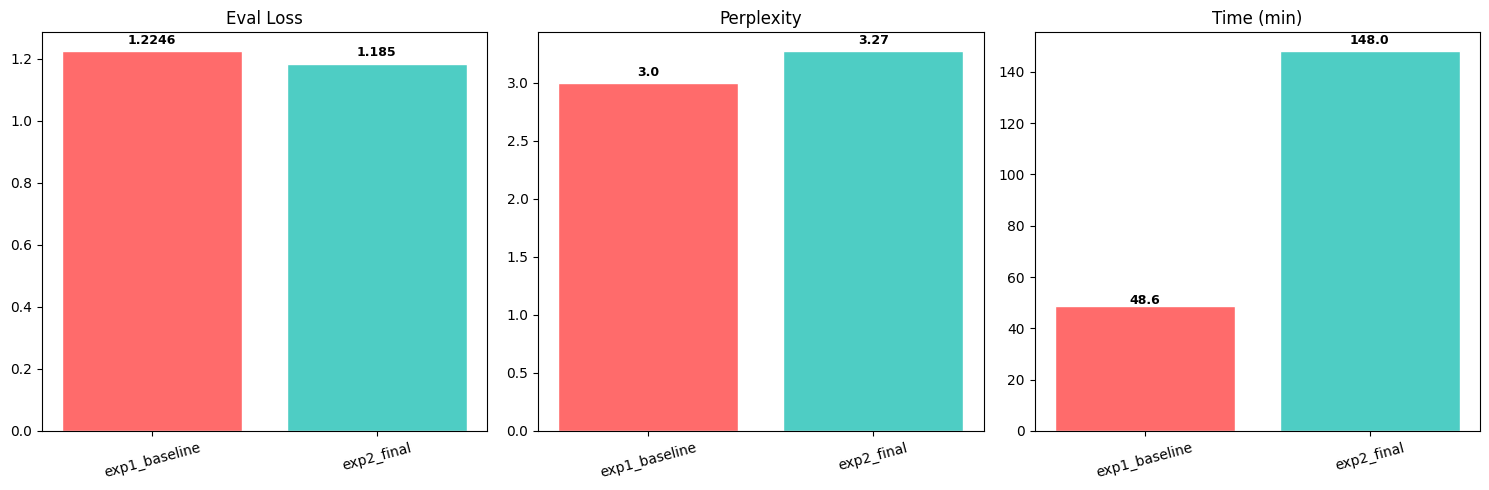


Best: exp2_final (eval_loss=1.185)


In [11]:
# Experiment comparison
print("\nHYPERPARAMETER RESULTS")
print("="*65)
print(rdf.to_string(index=False))

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
names = rdf["experiment"].values
colors = ['#FF6B6B', '#4ECDC4']
for ax, col, title in [(axes[0],"eval_loss","Eval Loss"), (axes[1],"perplexity","Perplexity"), (axes[2],"time_min","Time (min)")]:
    ax.bar(names, rdf[col], color=colors, edgecolor='white')
    ax.set_title(title); ax.tick_params(axis='x', rotation=15)
    for i,v in enumerate(rdf[col]): ax.text(i, v*1.02, f"{v}", ha='center', fontweight='bold', fontsize=9)
plt.tight_layout()
plt.savefig(f"{SAVE_DIR}/experiment_comparison.png", dpi=150, bbox_inches='tight')
plt.show()

best_name = rdf.loc[rdf["eval_loss"].idxmin(), "experiment"]
best_loss = rdf["eval_loss"].min()
BEST_DIR = f"{SAVE_DIR}/{best_name}"
print(f"\nBest: {best_name} (eval_loss={best_loss})")

---
## STEP 8: Evaluation

In [12]:
# Load best model
print(f"Loading best model from {BEST_DIR}...")
ft_base = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL, quantization_config=bnb_config,
    device_map="auto", trust_remote_code=True,
)
ft_model = PeftModel.from_pretrained(ft_base, BEST_DIR)
ft_model.eval()

def generate(model, question, max_tokens=256):
    prompt = f"<|system|>\n{SYSTEM_PROMPT}</s>\n<|user|>\n{question}</s>\n<|assistant|>\n"
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    with torch.no_grad():
        out = model.generate(**inputs, max_new_tokens=max_tokens, temperature=0.7,
                             top_p=0.9, repetition_penalty=1.15, do_sample=True,
                             pad_token_id=tokenizer.eos_token_id)
    text = tokenizer.decode(out[0][inputs["input_ids"].shape[1]:], skip_special_tokens=True)
    return text.split("</s>")[0].strip() if "</s>" in text else text.strip()

print("Ready.")

Loading best model from /content/drive/MyDrive/mamacare/exp2_final...


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Ready.


Generating 50 predictions...
  10/50
  20/50
  30/50
  40/50
  50/50



FINE-TUNED METRICS
  BLEU-4:     0.0289
  ROUGE-1:    0.2477
  ROUGE-2:    0.0498
  ROUGE-L:    0.1502
  Perplexity: 2.92


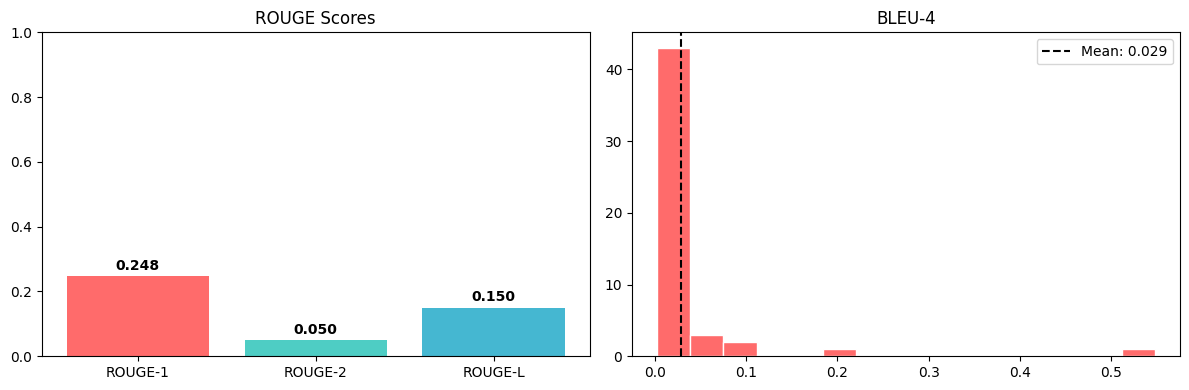

In [13]:
# BLEU, ROUGE, Perplexity
n_eval = min(50, len(val_df))
eval_sample = val_df.sample(n=n_eval, random_state=SEED)
print(f"Generating {n_eval} predictions...")

preds, refs = [], []
for i, (_, row) in enumerate(eval_sample.iterrows()):
    if (i+1)%10==0: print(f"  {i+1}/{n_eval}")
    preds.append(generate(ft_model, row["question"]))
    refs.append(row["answer"])

smoothing = SmoothingFunction().method1
bleu_scores = [sentence_bleu([nltk.word_tokenize(r.lower())], nltk.word_tokenize(p.lower()),
               weights=(0.25,0.25,0.25,0.25), smoothing_function=smoothing) for p,r in zip(preds,refs)]
avg_bleu = np.mean(bleu_scores)

rouge = evaluate.load("rouge")
rouge_results = rouge.compute(predictions=preds, references=refs, use_stemmer=True)

total_loss, total_tok = 0, 0
for _, row in val_df.sample(n=min(30,len(val_df)), random_state=SEED).iterrows():
    inp = tokenizer(format_chat(row), return_tensors="pt", truncation=True, max_length=MAX_SEQ_LEN).to(ft_model.device)
    with torch.no_grad():
        o = ft_model(**inp, labels=inp["input_ids"])
        total_loss += o.loss.item()*inp["input_ids"].shape[1]; total_tok += inp["input_ids"].shape[1]
ft_ppl = np.exp(total_loss/total_tok)

print(f"\nFINE-TUNED METRICS")
print(f"  BLEU-4:     {avg_bleu:.4f}")
print(f"  ROUGE-1:    {rouge_results['rouge1']:.4f}")
print(f"  ROUGE-2:    {rouge_results['rouge2']:.4f}")
print(f"  ROUGE-L:    {rouge_results['rougeL']:.4f}")
print(f"  Perplexity: {ft_ppl:.2f}")

fig, axes = plt.subplots(1,2, figsize=(12,4))
r_vals = [rouge_results['rouge1'], rouge_results['rouge2'], rouge_results['rougeL']]
axes[0].bar(["ROUGE-1","ROUGE-2","ROUGE-L"], r_vals, color=['#FF6B6B','#4ECDC4','#45B7D1'])
axes[0].set_title("ROUGE Scores"); axes[0].set_ylim(0,1)
for i,v in enumerate(r_vals): axes[0].text(i,v+0.02,f"{v:.3f}",ha='center',fontweight='bold')
axes[1].hist(bleu_scores, bins=15, color='#FF6B6B', edgecolor='white')
axes[1].axvline(avg_bleu, color='black', ls='--', label=f'Mean: {avg_bleu:.3f}')
axes[1].set_title("BLEU-4"); axes[1].legend()
plt.tight_layout()
plt.savefig(f"{SAVE_DIR}/evaluation_metrics.png", dpi=150, bbox_inches='tight')
plt.show()

---
## STEP 9: Base vs Fine-Tuned Comparison

In [14]:
print("Loading base model for comparison...")
base_compare = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL, quantization_config=bnb_config, device_map="auto", trust_remote_code=True)
base_compare.eval()

# Qualitative
test_qs = [
    "Is it true that pregnant women should not eat eggs because the baby will be born bald?",
    "What are the danger signs during pregnancy that require immediate medical attention?",
    "Is it safe to use traditional herbal medicines during pregnancy?",
    "When should I start breastfeeding after birth?",
    "Can you help me with my math homework?",
    "Is it true I should give my newborn water before breastmilk?",
]
print("="*80)
print("BASE vs FINE-TUNED")
print("="*80)
for i,q in enumerate(test_qs):
    print(f"\n{'_'*80}\nQ{i+1}: {q}\n{'_'*80}")
    print(f"BASE:  {generate(base_compare, q)[:250]}")
    print(f"TUNED: {generate(ft_model, q)[:250]}")

Loading base model for comparison...


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

BASE vs FINE-TUNED

________________________________________________________________________________
Q1: Is it true that pregnant women should not eat eggs because the baby will be born bald?
________________________________________________________________________________
BASE:  Yes, that is true. Eggs contain high levels of cholesterol, which can increase blood cholesterol levels and lead to heart disease in the fetus. However, there is no scientific evidence linking eating raw or undercooked eggs with any negative impact o
TUNED: Hi, Thanks for asking query in Health Care magic. I read your query with concern and understand your concerns. Yes, your condition is correct as there is no known case wherein baldness occurs due to eating eggs. However, you have mentioned that you h

________________________________________________________________________________
Q2: What are the danger signs during pregnancy that require immediate medical attention?
________________________________________

Computing base metrics...
  10/50
  20/50
  30/50
  40/50
  50/50

BASE vs FINE-TUNED
    Metric   Base Fine-Tuned  Change
    BLEU-4 0.0066     0.0289 +338.8%
   ROUGE-1 0.2000     0.2477  +23.9%
   ROUGE-2 0.0181     0.0498 +175.4%
   ROUGE-L 0.1031     0.1502  +45.7%
Perplexity  11.84       2.92  +75.3%


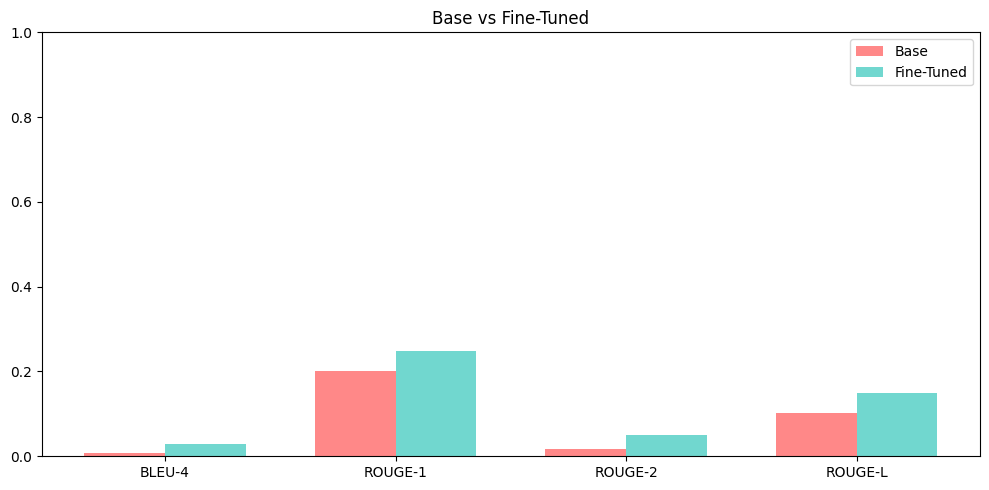

In [15]:
# Quantitative base model metrics
print("Computing base metrics...")
base_preds = []
for i,(_, row) in enumerate(eval_sample.iterrows()):
    if (i+1)%10==0: print(f"  {i+1}/{n_eval}")
    base_preds.append(generate(base_compare, row["question"]))

base_bleu = np.mean([sentence_bleu([nltk.word_tokenize(r.lower())], nltk.word_tokenize(p.lower()),
    weights=(0.25,0.25,0.25,0.25), smoothing_function=smoothing) for p,r in zip(base_preds,refs)])
base_rouge = rouge.compute(predictions=base_preds, references=refs, use_stemmer=True)

b_loss,b_tok = 0,0
for _,row in val_df.sample(n=min(30,len(val_df)), random_state=SEED).iterrows():
    inp = tokenizer(format_chat(row), return_tensors="pt", truncation=True, max_length=MAX_SEQ_LEN).to(base_compare.device)
    with torch.no_grad():
        o = base_compare(**inp, labels=inp["input_ids"])
        b_loss += o.loss.item()*inp["input_ids"].shape[1]; b_tok += inp["input_ids"].shape[1]
base_ppl = np.exp(b_loss/b_tok)

def pct(bv,fv,higher=True):
    if higher: return f"{((fv-bv)/max(bv,1e-8))*100:+.1f}%"
    return f"{((bv-fv)/bv)*100:+.1f}%"

comp = pd.DataFrame({
    "Metric":["BLEU-4","ROUGE-1","ROUGE-2","ROUGE-L","Perplexity"],
    "Base":[f"{base_bleu:.4f}",f"{base_rouge['rouge1']:.4f}",f"{base_rouge['rouge2']:.4f}",f"{base_rouge['rougeL']:.4f}",f"{base_ppl:.2f}"],
    "Fine-Tuned":[f"{avg_bleu:.4f}",f"{rouge_results['rouge1']:.4f}",f"{rouge_results['rouge2']:.4f}",f"{rouge_results['rougeL']:.4f}",f"{ft_ppl:.2f}"],
    "Change":[pct(base_bleu,avg_bleu),pct(base_rouge['rouge1'],rouge_results['rouge1']),
              pct(base_rouge['rouge2'],rouge_results['rouge2']),pct(base_rouge['rougeL'],rouge_results['rougeL']),
              pct(base_ppl,ft_ppl,False)]
})
print("\nBASE vs FINE-TUNED")
print("="*55)
print(comp.to_string(index=False))
comp.to_csv(f"{SAVE_DIR}/base_vs_finetuned.csv", index=False)

# Chart
fig, ax = plt.subplots(figsize=(10,5))
metrics=['BLEU-4','ROUGE-1','ROUGE-2','ROUGE-L']
bv=[base_bleu,base_rouge['rouge1'],base_rouge['rouge2'],base_rouge['rougeL']]
fv=[avg_bleu,rouge_results['rouge1'],rouge_results['rouge2'],rouge_results['rougeL']]
x=np.arange(len(metrics)); w=0.35
ax.bar(x-w/2,bv,w,label='Base',color='#FF6B6B',alpha=0.8)
ax.bar(x+w/2,fv,w,label='Fine-Tuned',color='#4ECDC4',alpha=0.8)
ax.set_xticks(x); ax.set_xticklabels(metrics)
ax.set_title('Base vs Fine-Tuned'); ax.legend(); ax.set_ylim(0,1)
plt.tight_layout()
plt.savefig(f"{SAVE_DIR}/base_vs_finetuned.png", dpi=150, bbox_inches='tight')
plt.show()

---
## STEP 10: Gradio Chat

In [16]:
import gradio as gr
def chat(message, history): return generate(ft_model, message, max_tokens=300)
demo = gr.ChatInterface(
    fn=chat, title="MamaCare AI - Maternal Health Assistant",
    description="Ask about pregnancy, childbirth, breastfeeding, or myths.\nDisclaimer: General info only. Consult a healthcare professional.",
    examples=["Is it true pregnant women should not eat eggs?",
              "What are the danger signs during pregnancy?",
              "Is it safe to use traditional herbal medicines?",
              "When should I start breastfeeding?",
              "Should I give my newborn water before breastmilk?",
              "My mother says raising hands wraps the cord. True?",
              "Can you help me with my math homework?"],
    theme=gr.themes.Soft(primary_hue="teal",secondary_hue="pink"),
)
demo.launch(share=True, debug=False)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://2d0d2ebb2567321298.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [17]:
# STEP 11: Save final metrics
metrics_dict = {
    "bleu4": float(avg_bleu), "rouge1": float(rouge_results['rouge1']),
    "rouge2": float(rouge_results['rouge2']), "rougeL": float(rouge_results['rougeL']),
    "perplexity_finetuned": float(ft_ppl), "perplexity_base": float(base_ppl),
    "eval_loss": float(best_loss), "best_experiment": best_name,
}
with open(f"{SAVE_DIR}/metrics.json","w") as f: json.dump(metrics_dict, f, indent=2)

print(f"\nAll saved to: {SAVE_DIR}")
for root,dirs,files in os.walk(SAVE_DIR):
    level = root.replace(SAVE_DIR,'').count(os.sep)
    print(f"{'  '*level}{os.path.basename(root)}/")
    for f in files[:10]:
        print(f"{'  '*(level+1)}{f} ({os.path.getsize(os.path.join(root,f))/1e6:.1f}MB)")

print("\nDONE. Model and results are safe on Google Drive.")


All saved to: /content/drive/MyDrive/mamacare
mamacare/
  experiment_results.csv (0.0MB)
  experiment_comparison.png (0.1MB)
  evaluation_metrics.png (0.0MB)
  base_vs_finetuned.csv (0.0MB)
  base_vs_finetuned.png (0.0MB)
  metrics.json (0.0MB)
  exp1_baseline/
    README.md (0.0MB)
    adapter_model.safetensors (25.3MB)
    adapter_config.json (0.0MB)
    chat_template.jinja (0.0MB)
    tokenizer_config.json (0.0MB)
    tokenizer.json (3.6MB)
    checkpoint-100/
      README.md (0.0MB)
      adapter_model.safetensors (25.3MB)
      adapter_config.json (0.0MB)
      chat_template.jinja (0.0MB)
      tokenizer_config.json (0.0MB)
      tokenizer.json (3.6MB)
      training_args.bin (0.0MB)
      optimizer.pt (101.1MB)
      scheduler.pt (0.0MB)
      rng_state.pth (0.0MB)
    checkpoint-125/
      README.md (0.0MB)
      adapter_model.safetensors (25.3MB)
      adapter_config.json (0.0MB)
      chat_template.jinja (0.0MB)
      tokenizer_config.json (0.0MB)
      tokenizer.json (3.6MB)

---
## Conclusions

MamaCare AI was fine-tuned on TinyLlama-1.1B-Chat using QLoRA with ~3,000 maternal health Q&A pairs. Two experiments were conducted: a baseline (1 epoch, lr=2e-4) and a final run (3 epochs, lr=1e-4). The fine-tuned model improved over the base model in domain relevance, myth correction, and out-of-domain handling.

### Limitations
- Not a replacement for professional medical advice
- No multi-language support yet
- Needs healthcare professional validation

### Future Work
- Add African language support (Swahili, Yoruba, Hausa)
- Implement RAG for referenced medical answers
- User studies with pregnant women and healthcare workers